<a href="https://colab.research.google.com/github/gizemkaratas/Miuul_ML_BitirmeProjesi/blob/main/asist_BitirmeProjesi_miuul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Makine Öğrenmesi ile Futbol Maç Sonucu Tahminlemesi**

## **Projenin Konusu ve Hedefi**

*  Bu projede, futbol maçlarında oyuncuların sarı kart görme olasılığını etkileyen faktörleri analiz edilerek ve bu bilgiler doğrultusunda gelecekteki maçlar için sarı kart tahminleme modeli oluşturuldu.
 İlk aşamada, oyuncuların yaşı, pozisyonu, oynadığı takım, teknik direktör, sahada kaldığı süre, maçın oynandığı stadyum, seyirci sayısı, maçın önemi ve hakem gibi değişkenleri dikkate alarak sarı kart görme olasılıklarını değerlendirildi.
 Bu analiz kapsamında, sarı kart görme eğilimlerini anlamak için keşifsel veri analizi ve görselleştirme tekniklerini kullanıldı. Elde edilen bulgular doğrultusunda, makine öğrenimi algoritmalarıyla gelecekteki maçlarda hangi oyuncuların sarı kart göreceğini tahmin eden bir model geliştirildi.
 Bu model, futbol kulüpleri ve teknik direktörler için oyuncu performansını optimize etmek, maç stratejilerini geliştirmek ve disiplin sorunlarını önceden tahmin ederek gerekli önlemleri almak konusunda önemli bir araç olarak kullanılabilir. Proje, futbol analitiği alanında yenilikçi bir yaklaşım sunarak veri odaklı karar alma süreçlerini desteklemeyi amaçlamaktadır.



**Gerekli Kütüphanelerin Yüklenmesi ve Ayarların Yapılması**

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib
from sklearn.exceptions import ConvergenceWarning

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

**Veri Setlerinin Yüklenmesi ve Dataframe Düzenlenmesi**

*   Birden fazla csv dosyasından alınan verilerin birleştirilmesi ve dflerin içinde gerekli olan columnların seçilmesi işlemi gerçekleştirildi.




In [28]:
# prompt: drive dosyasına erişsin

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# "appearances.csv" dosyasını okur ve "date" sütununu tarih formatında dönüştürür
app = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/appearances.csv", parse_dates=["date"])
# Sadece gerekli sütunları seçer: "game_id", "date", "player_id", "yellow_cards" ve "minutes_played"
app = app.loc[:, ["game_id", 'date', 'player_id', "yellow_cards", 'minutes_played']]

pl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/players.csv", parse_dates=["date_of_birth"])
pl = pl.loc[:, ['player_id', 'date_of_birth', 'position']]
# Eksik verileri (NaN) içeren satırları kaldırır
pl = pl.dropna()

g = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/games.csv")
g = g.loc[:, ['game_id', 'stadium', 'attendance', 'referee', 'competition_type']]
g = g.dropna()

ge = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/game_events.csv", parse_dates=["date"])
ge = ge.loc[:, ['game_id', 'date', 'minute', 'type', 'player_id', 'description']]
ge = ge.dropna()

cl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/clubs.csv")
cl = cl.loc[:, ['stadium_name', 'stadium_seats']]
# "stadium_name" sütununu "stadium" olarak yeniden adlandırır
cl = cl.rename(columns={"stadium_name": "stadium"})


**Veri Birleştirme**

In [30]:
# "ge" (game_events) ve "g" (games) DataFrame'lerini "game_id" sütunu üzerinden birleştirilmesi
df = pd.merge(ge, g, on='game_id', how='inner')

# Elde edilen DataFrame'i, "pl" (players) DataFrame'i ile "player_id" sütunu üzerinden birleştirilmesi
df = pd.merge(df, pl, on='player_id', how='inner')

# Sonuç DataFrame'ini, "app" (appearances) DataFrame'i ile "game_id", "date" ve "player_id" sütunları üzerinden birleştirilmesi
df = df.merge(app, on=['game_id', "date", "player_id"], how='inner')

# Sonuç DataFrame'ini, "cl" (clubs) DataFrame'i ile "stadium" sütunu üzerinden birleştirilmesi
df = df.merge(cl, on='stadium', how='inner')


**Veri Temizleme**

In [47]:
# Verideki hatalı veya sorun çıkaran kısımların çıkarılması
df = df[df["minute"] >= 0]
df = df[~(df["position"] == "Missing")]
df["attendance"] = df["attendance"].astype("int")


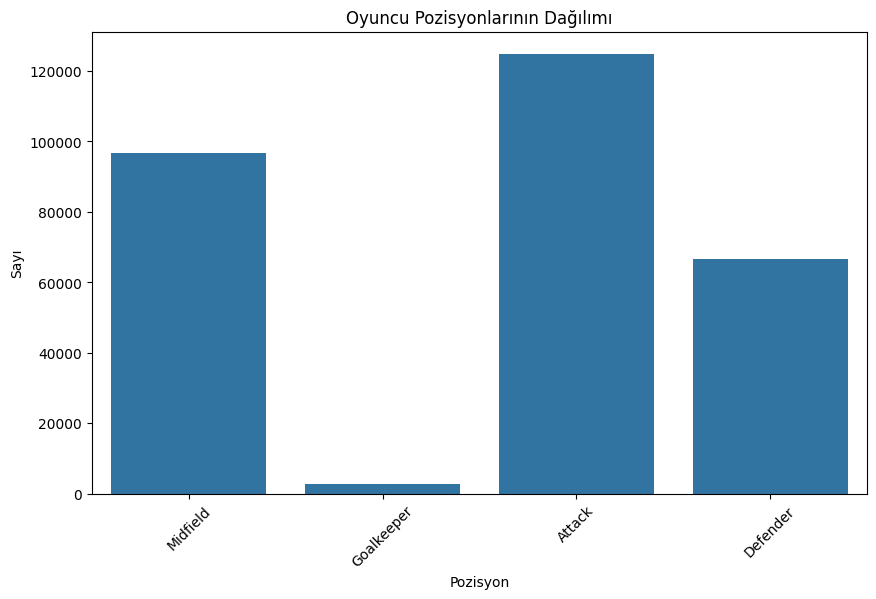

In [32]:
# prompt: grafik ekle

import matplotlib.pyplot as plt
# Örnek bir grafik ekleme
plt.figure(figsize=(10, 6))
sns.countplot(x='position', data=df)
plt.title('Oyuncu Pozisyonlarının Dağılımı')
plt.xlabel('Pozisyon')
plt.ylabel('Sayı')
plt.xticks(rotation=45)
plt.show()


**Yeni Değişken Oluşturma**

In [33]:
# Yeni değişkenler eklenmesi(ilk-son20 dk ve uzatmalar için)
df["last_20"] = [1 if ((i[2] >= 70 and i[2] <= 90) & (i[3] == "Cards")) else 0 for i in df.values]
df["first_20"] = [1 if ((i[2] <= 20 ) & (i[3] == "Cards")) else 0 for i in df.values]
df["extras"] = [1 if ((i[2] > 90 ) & (i[3] == "Cards")) else 0 for i in df.values]

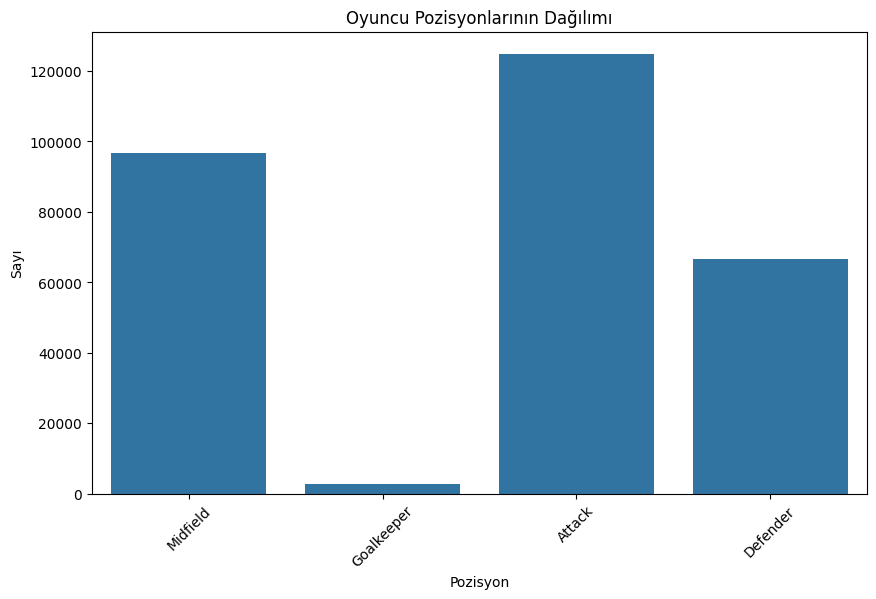

In [34]:
# prompt: grafik görsel ekle

import matplotlib.pyplot as plt
# Örnek bir grafik ekleme
plt.figure(figsize=(10, 6))
sns.countplot(x='position', data=df)
plt.title('Oyuncu Pozisyonlarının Dağılımı')
plt.xlabel('Pozisyon')
plt.ylabel('Sayı')
plt.xticks(rotation=45)
plt.show()


**Düzenleme**

In [48]:
# Stadyum kapasitelerini düzenleme
max_capacity_df = cl.groupby('stadium')['stadium_seats'].max().reset_index()
cl = cl.merge(max_capacity_df, on='stadium', how='inner', suffixes=('', '_max'))
cl = cl.drop_duplicates(subset=['stadium', 'stadium_seats_max'])

# Oyuncunun maç oynandığı tarihteki yaşının hesaplanması
df['age'] = df['date'].dt.year - df['date_of_birth'].dt.year

# Seyirci sayısı ve stadyum kapasitesi üzerinde doluluk oranı hesaplanması
df["attendance_rate"] = (df["attendance"] * 100) / df["stadium_seats_max"]

# Doluluk oranının uygun seviyelere çekilmesi
df = df[df["attendance_rate"] <= 100.0]

# Maçlara atanan hakemlerin kart performansı hesabı ve veriyle birleştirilmesi
referee_card_avg = df.groupby('referee')['yellow_cards'].mean().reset_index()
referee_card_avg.columns = ['referee', 'referee_card_avg']
df = df.merge(referee_card_avg, on='referee', how='inner')

# Maçların önemine göre değer ataması yapılması
importance_mapping = {
    'domestic_league': 1,
    'domestic_cup': 2,
    'international_cup': 3,
    'others': 0
}
df['importance'] = df['competition_type'].apply(lambda x: importance_mapping.get(x, 0))

# Oyuncuların yaşlarına göre deneyim değeri ataması
bins = [15, 24, 33, 42]
labels = [1, 2, 3]
df['experience'] = pd.cut(df['age'], bins=bins, labels=labels, right=True, include_lowest=True)
df['experience'] = df['experience'].astype('int')

KeyError: 'stadium_seats_max'

In [49]:
#Veri setindeki kullanılmayacak columnların temizlenmesi
df = df.drop(['game_id', 'date', 'type', 'minute','description', 'date_of_birth','stadium_seats',
       'stadium_seats_max', 'competition_type', 'stadium'], axis=1)
df.to_csv('output.csv', index=False)


KeyError: "['stadium_seats_max'] not found in axis"

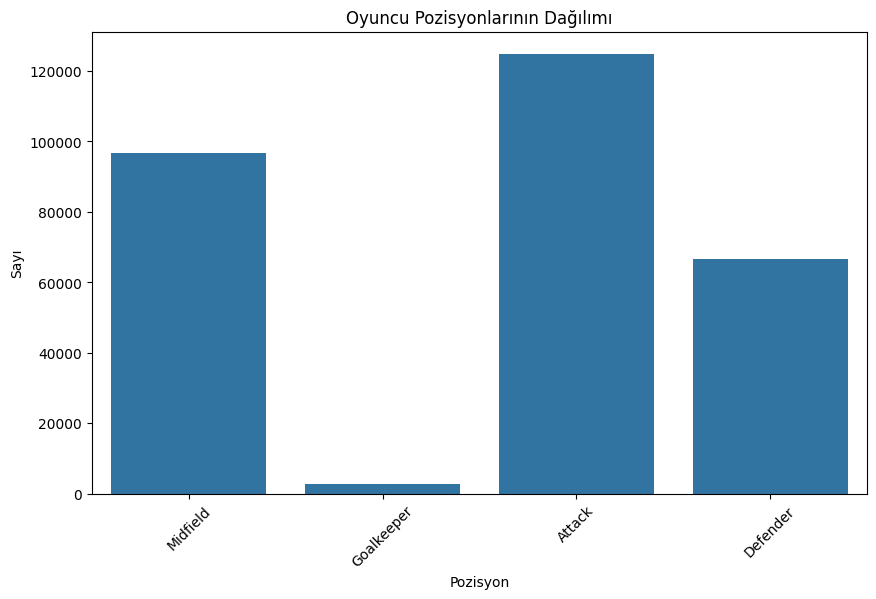

In [36]:
# prompt: görsel grafik ekle

import matplotlib.pyplot as plt
# Örnek bir grafik ekleme
plt.figure(figsize=(10, 6))
sns.countplot(x='position', data=df)
plt.title('Oyuncu Pozisyonlarının Dağılımı')
plt.xlabel('Pozisyon')
plt.ylabel('Sayı')
plt.xticks(rotation=45)
plt.show()


**Veri Önizleme**

In [37]:
def check_df(dataframe):
    print("##################### Boyut #####################")
    print(dataframe.shape)
    print("##################### Türler #####################")
    print(dataframe.dtypes)
    print("##################### İlk 3 Kayıt #####################")
    print(dataframe.head(3))
    print("##################### Son 3 Kayıt #####################")
    print(dataframe.tail(3))
    print("##################### Eksik Değerler #####################")
    print(dataframe.isnull().sum())
    print("##################### Yüzdelikler #####################")
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    print(dataframe[numeric_columns].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)


##################### Boyut #####################
(290998, 19)
##################### Türler #####################
game_id                      int64
date                datetime64[ns]
minute                       int64
type                        object
player_id                    int64
description                 object
stadium                     object
attendance                   int64
referee                     object
competition_type            object
date_of_birth       datetime64[ns]
position                    object
yellow_cards                 int64
minutes_played               int64
stadium_seats                int64
last_20                      int64
first_20                     int64
extras                       int64
age                          int32
dtype: object
##################### İlk 3 Kayıt #####################
   game_id       date  minute           type  player_id  \
0  2211607 2012-08-05      77          Cards       4425   
1  2250259 2012-11-03      78    

**Kategorik Değişkenlerin Belirlenmesi**



In [38]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Gözlemler: {dataframe.shape[0]}")
    print(f"Değişkenler: {dataframe.shape[1]}")
    print(f'Kategorik Sütunlar: {len(cat_cols)}')
    print(f'Sayısal Sütunlar: {len(num_cols)}')
    print(f'Yüksek Kardinaliteli Kategorik Sütunlar: {len(cat_but_car)}')
    print(f'Sayısal Görünen Kategorik Sütunlar: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Gözlemler: 290998
Değişkenler: 19
Kategorik Sütunlar: 7
Sayısal Sütunlar: 9
Yüksek Kardinaliteli Kategorik Sütunlar: 3
Sayısal Görünen Kategorik Sütunlar: 4


In [39]:
# prompt: görsel grafik ekle

import plotly.express as px

# Örnek bir görsel grafik ekleme
fig = px.scatter(df, x='minutes_played', y='yellow_cards', color='position',
                 title='Oyun Süresi ve Sarı Kart İlişkisi',
                 labels={'minutes_played': 'Oyun Süresi (dakika)', 'yellow_cards': 'Sarı Kart Sayısı'})
fig.show()


**Değişken Analizi**

               HEDEF_ORTALAMA
type                         
Cards                   1.028
Goals                   0.153
Substitutions           0.148


                   HEDEF_ORTALAMA
competition_type                 
domestic_cup                0.319
domestic_league             0.371
international_cup           0.346
other                       0.315


            HEDEF_ORTALAMA
position                  
Attack               0.233
Defender             0.558
Goalkeeper           0.726
Midfield             0.397


              HEDEF_ORTALAMA
yellow_cards                
0                      0.000
1                      1.000
2                      2.000


         HEDEF_ORTALAMA
last_20                
0                 0.297
1                 1.025


          HEDEF_ORTALAMA
first_20                
0                  0.353
1                  1.018


        HEDEF_ORTALAMA
extras                
0                0.366
1                1.042


                 game_id
yellow_cards

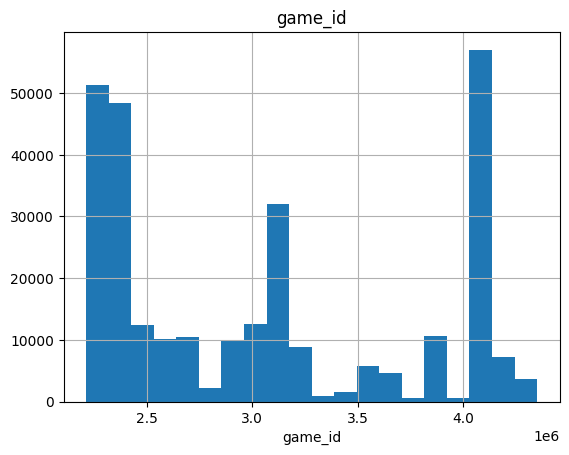

count                           290998
mean     2018-02-26 22:10:16.037223424
min                2012-07-05 00:00:00
5%                 2012-10-28 00:00:00
10%                2013-01-13 00:00:00
20%                2013-09-14 00:00:00
30%                2014-03-01 00:00:00
40%                2015-11-08 00:00:00
50%                2018-05-06 00:00:00
60%                2019-02-10 00:00:00
70%                2021-10-03 00:00:00
80%                2023-09-17 00:00:00
90%                2024-01-26 00:00:00
95%                2024-03-29 00:00:00
99%                2024-05-12 00:00:00
max                2024-06-02 00:00:00
Name: date, dtype: object


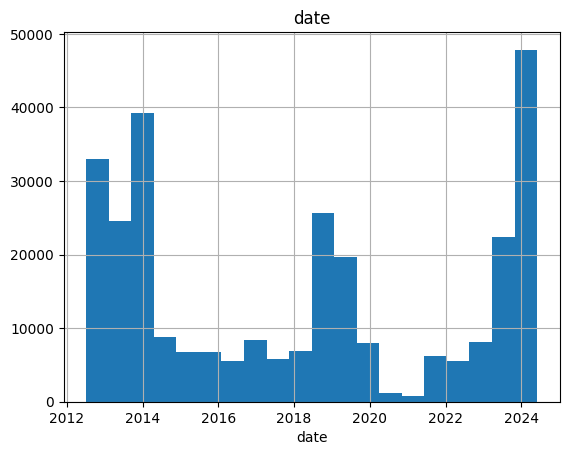

count   290998.000
mean        58.812
std         24.302
min          1.000
5%          12.000
10%         21.000
20%         36.000
30%         46.000
40%         57.000
50%         64.000
60%         70.000
70%         76.000
80%         82.000
90%         88.000
95%         90.000
99%         90.000
max        120.000
Name: minute, dtype: float64


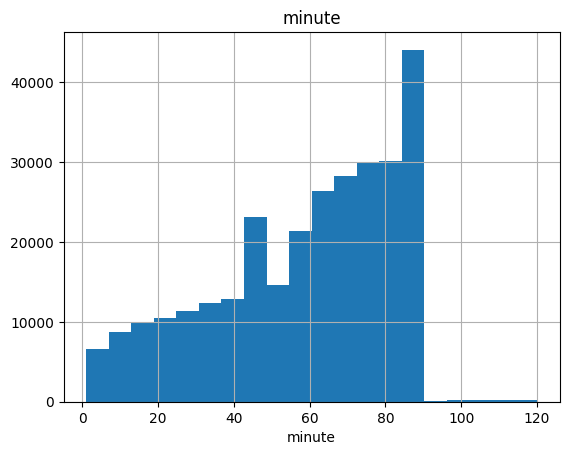

count    290998.000
mean     188233.151
std      189567.071
min          10.000
5%        10254.850
10%       21782.000
20%       39381.000
30%       56808.000
40%       80191.000
50%      119557.000
60%      169368.000
70%      235565.200
80%      329812.000
90%      463618.000
95%      588649.000
99%      820374.000
max     1229924.000
Name: player_id, dtype: float64


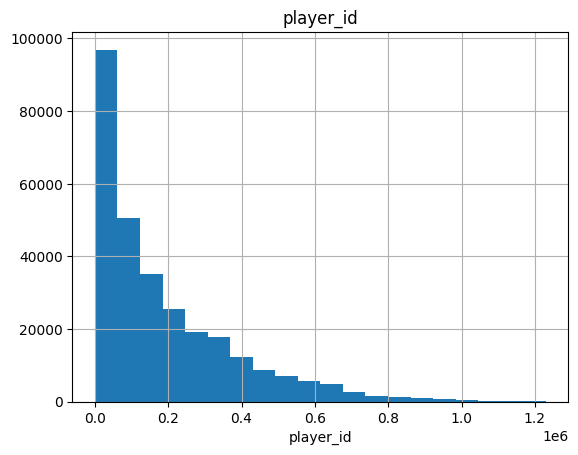

count   290998.000
mean     22047.438
std      18625.815
min         23.000
5%        1545.000
10%       2812.000
20%       5592.000
30%       8908.000
40%      12601.000
50%      16703.000
60%      21500.000
70%      28323.000
80%      37744.000
90%      50123.000
95%      60107.000
99%      75380.000
max      85454.000
Name: attendance, dtype: float64


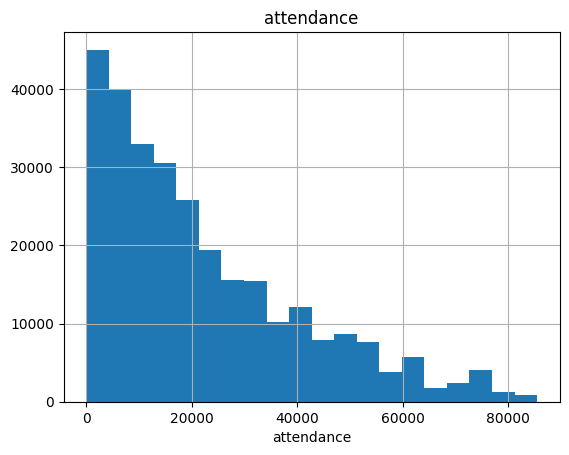

count                           290998
mean     1991-08-21 06:41:34.186214400
min                1971-05-18 00:00:00
5%                 1982-01-05 00:00:00
10%                1984-01-25 00:00:00
20%                1986-08-04 00:00:00
30%                1988-04-21 00:00:00
40%      1989-12-28 19:12:00.000000256
50%                1991-06-28 00:00:00
60%                1993-02-07 00:00:00
70%                1994-10-24 00:00:00
80%                1997-01-23 00:00:00
90%                1999-07-05 00:00:00
95%                2001-05-14 00:00:00
99%                2003-12-16 00:00:00
max                2008-02-12 00:00:00
Name: date_of_birth, dtype: object


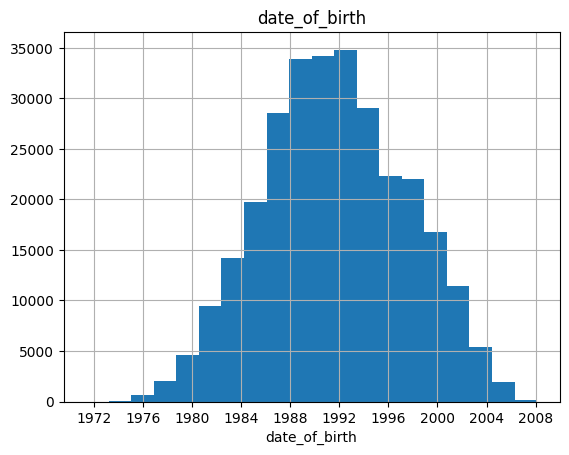

count   290998.000
mean        74.951
std         20.576
min          1.000
5%          26.000
10%         45.000
20%         62.000
30%         71.000
40%         77.000
50%         83.000
60%         90.000
70%         90.000
80%         90.000
90%         90.000
95%         90.000
99%         90.000
max        135.000
Name: minutes_played, dtype: float64


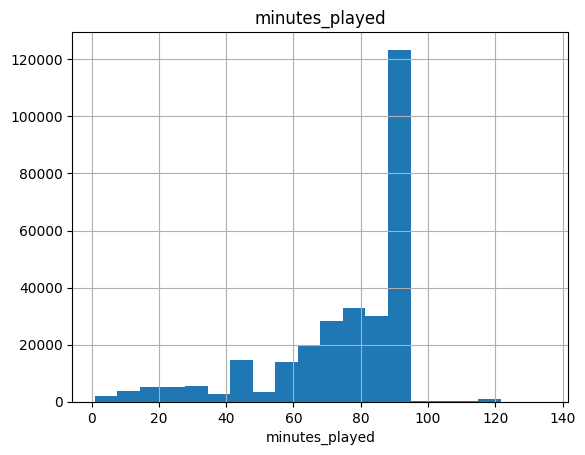

count   290998.000
mean     31761.770
std      20293.275
min       1312.000
5%        7000.000
10%       9512.000
20%      12771.000
30%      18128.000
40%      22000.000
50%      28000.000
60%      31800.000
70%      39211.000
80%      49430.000
90%      63026.000
95%      74879.000
99%      81044.000
max      81365.000
Name: stadium_seats, dtype: float64


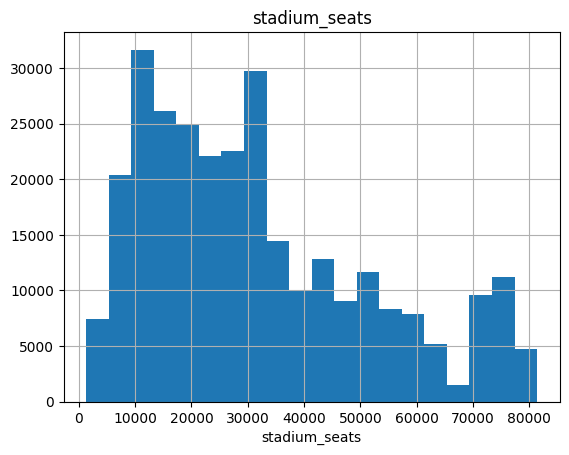

count   290998.000
mean        26.460
std          4.070
min         15.000
5%          20.000
10%         21.000
20%         23.000
30%         24.000
40%         25.000
50%         26.000
60%         27.000
70%         29.000
80%         30.000
90%         32.000
95%         34.000
99%         36.000
max         42.000
Name: age, dtype: float64


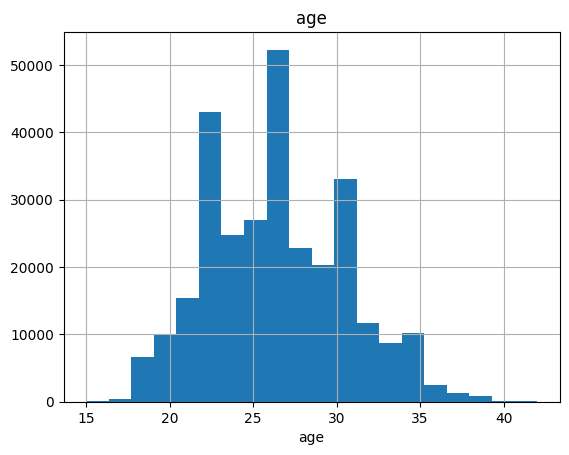

                 type  Ratio
type                        
Goals          123998 42.611
Substitutions   95513 32.823
Cards           71487 24.566
##########################################


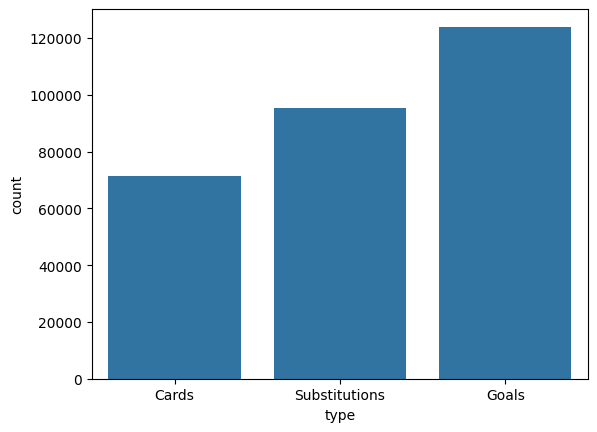

                   competition_type  Ratio
competition_type                          
domestic_league              256984 88.311
international_cup             18073  6.211
domestic_cup                  15077  5.181
other                           864  0.297
##########################################


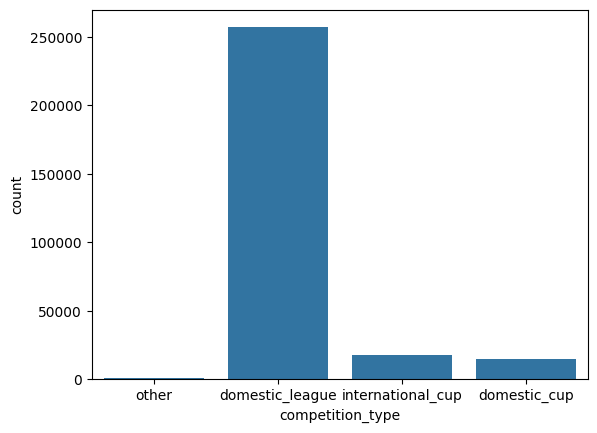

            position  Ratio
position                   
Attack        124946 42.937
Midfield       96821 33.272
Defender       66557 22.872
Goalkeeper      2674  0.919
##########################################


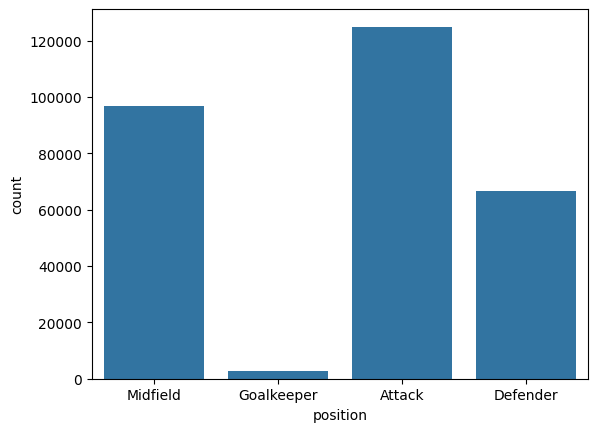

              yellow_cards  Ratio
yellow_cards                     
0                   188565 64.799
1                    98285 33.775
2                     4148  1.425
##########################################


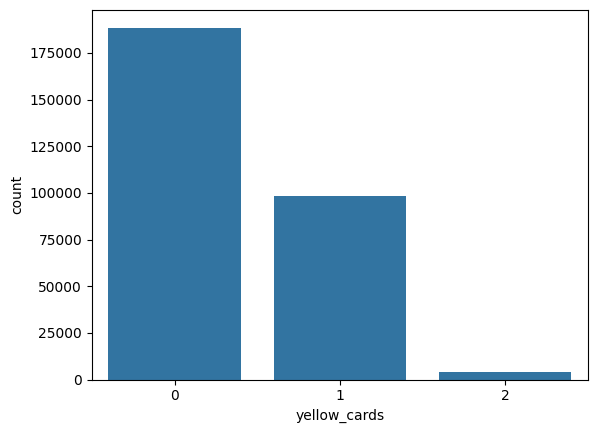

         last_20  Ratio
last_20                
0         263226 90.456
1          27772  9.544
##########################################


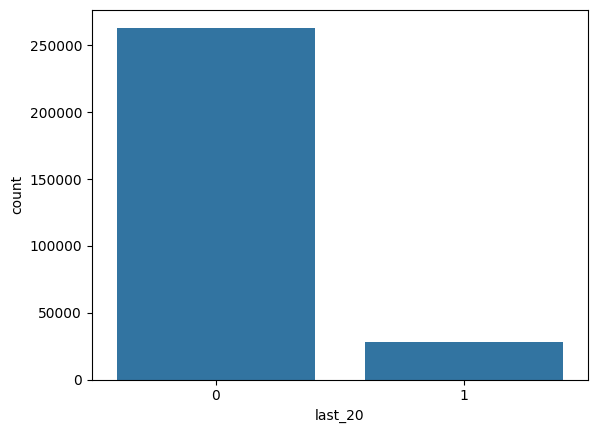

          first_20  Ratio
first_20                 
0           285002 97.940
1             5996  2.060
##########################################


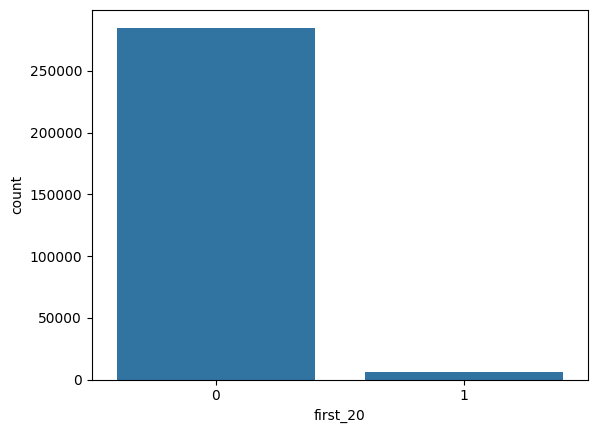

        extras  Ratio
extras               
0       290759 99.918
1          239  0.082
##########################################


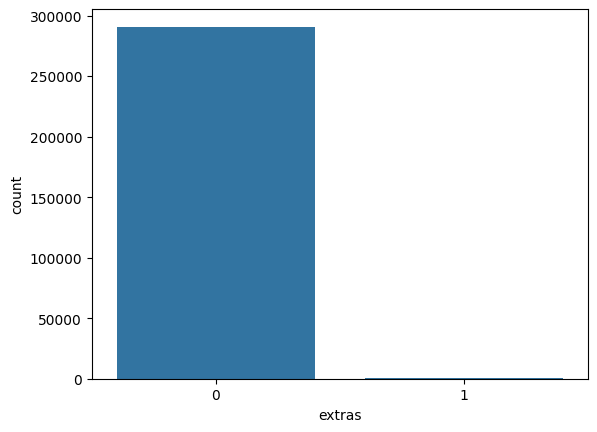

In [40]:
# Kategorik değişkenlerin hedef değişken ile ilişkisinin incelenmesi
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"HEDEF_ORTALAMA": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "yellow_cards", col)

# Sayısal değişkenlerin hedef değişken ile ilişkisinin incelenmesi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "yellow_cards", col)

# Sayısal değişkenlerin özeti ve görselleştirilmesi
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)
    # Kategorik değişkenlerin özeti ve görselleştirilmesi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].
                        value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

In [41]:
# prompt: görsel grafik ekle

# Örnek bir görsel grafik ekleme
fig = px.scatter(df, x='minutes_played', y='yellow_cards', color='position',
                 title='Oyun Süresi ve Sarı Kart İlişkisi',
                 labels={'minutes_played': 'Oyun Süresi (dakika)', 'yellow_cards': 'Sarı Kart Sayısı'})
fig.show()


**Korelasyon Analizi**

In [42]:
# Korelasyon analizi ve görselleştirme
data = df.copy()
data = data.drop(columns=['referee', 'position'])

# Korelasyon matrisini hesaplama
correlation_matrix = data.corr()

# Sadece yellow_cards ile korelasyonları alma
yellow_card_correlations = correlation_matrix['yellow_cards'].drop('yellow_cards')

# Korelasyonları görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(yellow_card_correlations.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Sarı Kartlarla Özelliklerin Korelasyonu')
plt.show()


ValueError: could not convert string to float: 'Cards'

In [43]:
# prompt: görsel grafik ekle

# Örnek bir görsel grafik ekleme
fig = px.scatter(df, x='minutes_played', y='yellow_cards', color='position',
                 title='Oyun Süresi ve Sarı Kart İlişkisi',
                 labels={'minutes_played': 'Oyun Süresi (dakika)', 'yellow_cards': 'Sarı Kart Sayısı'})
fig.show()


**Görselleştirmeler**

In [44]:
# 3. Hakemlerin sarı kart verme ortalamasına göre sarı kart dağılımı
plt.figure(figsize=(10, 6))
sns.boxplot(x='yellow_cards', y='referee_card_avg', data=df)
plt.title('Hakemlerin Sarı Kart Verme Ortalamasına Göre Sarı Kart Dağılımı')
plt.xlabel("Sarı Kart Sayısı")
plt.ylabel("Hakemin Sarı Kart Verme Ortalaması")
plt.show()

# 4. Maç doluluk oranına göre sarı kart ortalaması
attendance_rate_mean_yellow_cards = df.groupby('attendance_rate')['yellow_cards'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='attendance_rate', y='yellow_cards', data=attendance_rate_mean_yellow_cards)
plt.title('Maç Doluluk Oranına Göre Sarı Kart Ortalaması')
plt.xlabel("Maç Doluluk Oranı (%)")
plt.ylabel("Sarı Kart Ortalaması")
plt.show()

# 6. Mevkine göre sarı kart ortalaması
position_mean_yellow_cards = df.groupby('position')['yellow_cards'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='position', y='yellow_cards', data=position_mean_yellow_cards)
plt.title('Mevkine Göre Sarı Kart Ortalaması')
plt.xlabel("Mevki")
plt.ylabel("Sarı Kart Ortalaması")
plt.show()


ValueError: Could not interpret value `referee_card_avg` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [45]:
# prompt: görsel grafik ekle

# Örnek bir görsel grafik ekleme
fig = px.scatter(df, x='minutes_played', y='yellow_cards', color='position',
                 title='Oyun Süresi ve Sarı Kart İlişkisi',
                 labels={'minutes_played': 'Oyun Süresi (dakika)', 'yellow_cards': 'Sarı Kart Sayısı'})
fig.show()


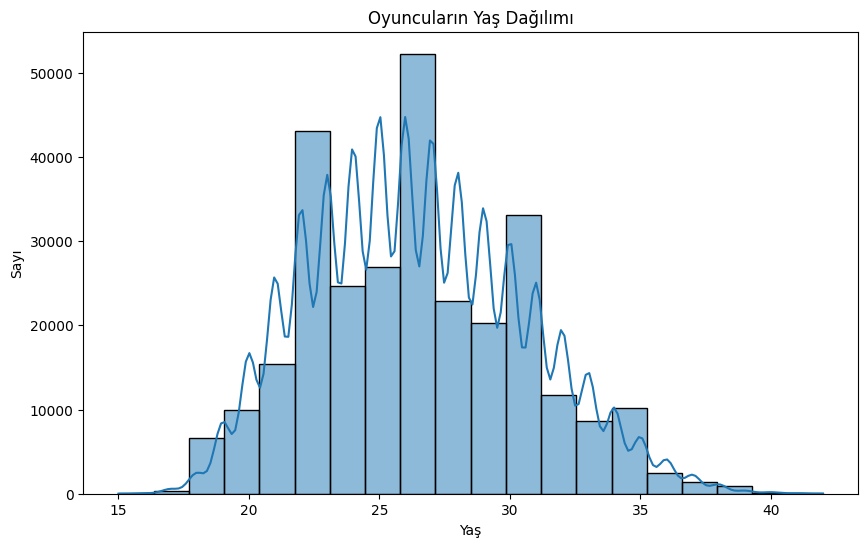

In [46]:
# prompt: bir tane daha grafik ekle

import matplotlib.pyplot as plt
# Örnek bir görsel grafik ekleme
fig = px.scatter(df, x='minutes_played', y='yellow_cards', color='position',
                 title='Oyun Süresi ve Sarı Kart İlişkisi',
                 labels={'minutes_played': 'Oyun Süresi (dakika)', 'yellow_cards': 'Sarı Kart Sayısı'})
fig.show()

# Oyuncuların yaş dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Oyuncuların Yaş Dağılımı')
plt.xlabel('Yaş')
plt.ylabel('Sayı')
plt.show()
